# CatBoost 기반 매출 급락 예측 모델

In [ ]:
!pip install koreanize_matplotlib
!pip install catboost
!pip install lifelines

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 13.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=6ad05cad812da7b0982ff83054bf5d21e59e6f96b1722d92fcccc68fb7c6052e
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:
import os
import pandas as pd
import numpy as np
import re, unicodedata, warnings
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from scipy.stats import spearmanr, mannwhitneyu
from collections import defaultdict
from sklearn.metrics import (average_precision_score, roc_auc_score, f1_score,
                             precision_score, recall_score, confusion_matrix,
                             mean_absolute_error, cohen_kappa_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from sklearn.inspection import permutation_importance
import sys, time

from typing import Callable, Dict, List, Tuple

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 200)

GLOBAL_SEED = 42
import os, random, numpy as np
def set_global_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_global_seed(GLOBAL_SEED)

In [ ]:
total_df = pd.read_csv('total_df.csv')
total_df["ref_year_month"] = pd.to_datetime(total_df["ref_year_month"], format="%Y-%m").dt.to_period("M")
total_df.head()

,store_id,store_address,store_name,brand_code,industry,business_district,open_date,close_date,store_address_detail,is_closed,industry_group,x,y,is_delivery,static_cluster,ref_year_month,operation_months_range,sales_amount_range,sales_count_range,unique_customers_range,avg_spending_range,cancel_rate_range,delivery_sales_ratio,industry_sales_ratio,industry_sales_count_ratio,industry_sales_rank_ratio,district_sales_rank_ratio,industry_closure_ratio,district_closure_ratio,male_20_under_ratio,male_30_ratio,male_40_ratio,male_50_ratio,male_60_over_ratio,female_20_under_ratio,female_30_ratio,female_40_ratio,female_50_ratio,female_60_over_ratio,returning_customer_ratio,new_customer_ratio,resident_customer_ratio,worker_customer_ratio,floating_customer_ratio,young_ratio,core_ratio,senior_ratio,male_ratio,female_ratio
0,16184E93D9,서울 성동구 마장동,성우**,UNK,축산물,마장동,2013-03-20,NaN,마장동,False,식품,127.045326,37.56638,False,8,2024-05,2,3,4,4,2,6.0,NaN,70.4,33.9,27.2,20.8,12.3,5.6,4.1480,9.044,11.0840,19.4480,24.2760,1.9520,4.256,5.2160,9.1520,11.4240,18.82,6.47,50.0,7.1,42.9,19.4,16.3,64.3,68.0000,32.0000
1,16184E93D9,서울 성동구 마장동,성우**,UNK,축산물,마장동,2013-03-20,NaN,마장동,False,식품,127.045326,37.56638,False,8,2023-04,2,4,4,4,2,6.0,NaN,74.6,22.9,11.5,21.3,11.3,6.0,3.9864,11.174,9.4224,16.9120,18.9052,2.6136,7.326,6.1776,11.0880,12.3948,16.51,5.05,25.0,6.3,68.8,25.1,15.6,59.3,60.4000,39.6000
2,16184E93D9,서울 성동구 마장동,성우**,UNK,축산물,마장동,2013-03-20,NaN,마장동,False,식품,127.045326,37.56638,False,8,2023-08,2,3,4,4,2,1.0,NaN,85.6,22.1,11.5,20.6,12.0,5.4,3.9060,11.214,10.6470,17.4510,19.7820,2.2940,6.586,6.2530,10.2490,11.6180,16.98,6.60,17.6,0.0,82.4,24.0,16.9,59.1,63.0000,37.0000
3,16184E93D9,서울 성동구 마장동,성우**,UNK,축산물,마장동,2013-03-20,NaN,마장동,False,식품,127.045326,37.56638,False,8,2024-02,2,3,4,4,1,1.0,NaN,90.5,35.8,27.8,22.2,12.3,5.0,4.7056,10.380,10.3800,21.8672,21.8672,2.0944,4.620,4.6200,9.7328,9.7328,16.95,9.60,15.8,5.3,78.9,21.8,15.0,63.2,69.2000,30.8000
4,16184E93D9,서울 성동구 마장동,성우**,UNK,축산물,마장동,2013-03-20,NaN,마장동,False,식품,127.045326,37.56638,False,8,2024-06,2,3,4,4,1,1.0,NaN,81.1,27.5,26.9,21.0,12.2,5.6,3.9345,7.869,10.8360,18.1245,23.6715,2.1655,4.331,5.9640,9.9755,13.0285,20.96,4.79,26.7,0.0,73.3,18.3,16.8,64.8,64.4355,35.4645


## EDA

In [ ]:
# =========================
# EDA for "+2 악화" 위기 징후 타당성 검증
# (가설1: 빈도/충격, 가설2: 지속성, 가설4: 결과 연계(대리지표))
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List, Optional

# ---------- 0) 준비: 헬퍼 ----------
def _prep_panel(df: pd.DataFrame) -> pd.DataFrame:
    s = df.copy()
    # 정렬 & 기본 타입 보정
    s = s.sort_values(["store_id","ref_year_month"]).reset_index(drop=True)
    # 등급(1..6) → int
    s["sales_amount_range"] = s["sales_amount_range"].astype(int)
    # 다음 달 등급 붙이기 (전이)
    g = s.groupby("store_id", group_keys=False)
    s["y_t"]   = s["sales_amount_range"]
    s["y_t1"]  = g["sales_amount_range"].shift(-1)
    s["delta"] = s["y_t1"] - s["y_t"]
    # 월 메타
    s["month"] = s["ref_year_month"].astype(str)
    s["quarter"] = s["ref_year_month"].dt.quarter
    # 하위권(5~6)
    s["low56_t"]  = (s["y_t"]  >= 5).astype(int)
    s["low56_t1"] = (s["y_t1"] >= 5).astype(int)
    return s

def _filter_window(s: pd.DataFrame, start: str="2023-01", end: str="2024-12") -> pd.DataFrame:
    # 분석 구간(이전/이후 창 확보하려면 더 타이트하게 잡아도 됨)
    mask = (s["ref_year_month"] >= pd.Period(start)) & (s["ref_year_month"] <= pd.Period(end))
    return s.loc[mask].copy()

# ---------- 1) 가설1: 빈도/충격 ----------
def transition_and_delta_stats(s: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    # 전이행렬: y_t → y_{t+1}
    valid = s.dropna(subset=["y_t","y_t1"])
    pivot = pd.crosstab(valid["y_t"], valid["y_t1"], normalize="index").round(4)
    # 변동폭 분포
    delta_dist = valid["delta"].value_counts(normalize=True).sort_index().to_frame("ratio").round(4)
    # 요약 막대: 유지/±1/≥±2
    def bucket(d):
        if d == 0: return "0"
        if abs(d) == 1: return "±1"
        return "≥±2"
    delta_bucket = valid["delta"].map(bucket).value_counts(normalize=True).rename_axis("bucket").to_frame("ratio").round(4)
    # 세그먼트별 +2 악화 발생률 (업종/분기/상권)
    seg_cols = [c for c in ["industry_group","business_district","quarter"] if c in s.columns]
    seg_rates = {}
    if seg_cols:
        for c in seg_cols:
            tmp = valid.assign(worsen_ge2=(valid["delta"]>=2).astype(int)).groupby(c)["worsen_ge2"].mean().sort_values(ascending=False).to_frame("rate").round(4)
            seg_rates[c] = tmp
    return {"transition": pivot, "delta_dist": delta_dist, "delta_bucket": delta_bucket, **{f"rate_by_{k}":v for k,v in seg_rates.items()}}

    # ---------- 2) 가설2: 지속성 ----------
# 사건 정의: t에서 delta>=2 (즉 y_{t+1} - y_t >= 2). 사건월은 기준 t.
# 사건-윈도우 패널 구축: k in {-3,-2,-1,0,+1,+2,+3,+6}
def build_event_window_panel(s: pd.DataFrame,
                             lags: List[int]=[-3,-2,-1,0,1,2,3,6],
                             seed: int=42,
                             match_max_per_treated: int=3) -> Dict[str, pd.DataFrame]:
    rng = np.random.RandomState(seed)
    base = s.dropna(subset=["y_t","y_t1"]).copy()
    base["event_worsen_ge2"] = (base["delta"]>=2).astype(int)
    # 사건 샘플(기준은 t월)
    treated = base.loc[base["event_worsen_ge2"]==1, ["store_id","ref_year_month","y_t","industry_group","business_district","quarter"]].copy()
    treated = treated.rename(columns={"ref_year_month":"t_period"})
    if treated.empty:
        return {"event_panel_treated": pd.DataFrame(), "event_panel_control": pd.DataFrame()}
    # 통제군 후보: 같은 t월의 관측 중 delta<2
    control_cand = base.loc[base["event_worsen_ge2"]==0, ["store_id","ref_year_month","y_t","industry_group","business_district","quarter"]].copy()
    control_cand = control_cand.rename(columns={"ref_year_month":"t_period"})

    # 매칭: 우선순위 (y_t, industry_group, business_district, quarter) 완전 일치 → 없으면 (y_t, quarter)만
    treated["_key1"] = list(zip(treated["y_t"], treated.get("industry_group",""), treated.get("business_district",""), treated["quarter"]))
    control_cand["_key1"] = list(zip(control_cand["y_t"], control_cand.get("industry_group",""), control_cand.get("business_district",""), control_cand["quarter"]))
    treated["_key2"] = list(zip(treated["y_t"], treated["quarter"]))
    control_cand["_key2"] = list(zip(control_cand["y_t"], control_cand["quarter"]))

    pairs = []
    for idx, row in treated.iterrows():
        # 같은 t월에서만 매칭(동시적 환경 유사화)
        cand = control_cand.loc[control_cand["t_period"]==row["t_period"]]
        # strict key1
        c1 = cand.loc[cand["_key1"]==row["_key1"]]
        if len(c1) < 1:
            c1 = cand.loc[cand["_key2"]==row["_key2"]]
        if len(c1) < 1:
            continue
        # 최대 match_max_per_treated개 샘플 추출
        take = min(match_max_per_treated, len(c1))
        sel = c1.sample(n=take, random_state=rng)
        for _, crow in sel.iterrows():
            pairs.append({"store_id_t": row["store_id"], "t_period": row["t_period"],
                          "store_id_c": crow["store_id"]})

    if not pairs:
        return {"event_panel_treated": pd.DataFrame(), "event_panel_control": pd.DataFrame()}

    pairs_df = pd.DataFrame(pairs).drop_duplicates()

    # 윈도우 붙이기: k relative offset
    def extract_window(sub: pd.DataFrame, store_col: str) -> pd.DataFrame:
        sub = sub.copy()
        out = []
        # 빠르게 조인하기 위해 원본에 인덱스 키 만들기
        s2 = s.copy()
        s2["ym"] = s2["ref_year_month"]
        s2 = s2.set_index(["store_id","ym"]).sort_index()
        for _, r in sub.iterrows():
            sid = r[store_col]
            t0  = r["t_period"]
            for k in lags:
                tk = (t0 + k) if isinstance(t0, pd.Period) else pd.Period(t0, freq="M") + k
                if (sid, tk) in s2.index:
                    rowk = s2.loc[(sid, tk)]
                    out.append({
                        "store_id": sid, "t0": t0, "k": k,
                        "y": int(rowk["sales_amount_range"]),
                        "low56": int(rowk["sales_amount_range"]>=5),
                        "sales_count_range": rowk["sales_count_range"] if "sales_count_range" in s2.columns else np.nan,
                        "unique_customers_range": rowk["unique_customers_range"] if "unique_customers_range" in s2.columns else np.nan,
                        "cancel_rate_range": rowk["cancel_rate_range"] if "cancel_rate_range" in s2.columns else np.nan
                    })
        return pd.DataFrame(out)

    treated_panel = extract_window(pairs_df.rename(columns={"store_id_t":"store_id"}), "store_id")
    control_panel = extract_window(pairs_df.rename(columns={"store_id_c":"store_id"}), "store_id")

    return {"event_panel_treated": treated_panel, "event_panel_control": control_panel}

def summarize_event_windows(treated_panel: pd.DataFrame, control_panel: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    # 평균 경로 (등급, 하위권 비율, 보조 지표)
    def agg(panel):
        if panel.empty: return {}
        m1 = panel.groupby("k")["y"].mean().rename("mean_grade")
        m2 = panel.groupby("k")["low56"].mean().rename("low56_rate")
        out = [m1, m2]
        for c in ["sales_count_range","unique_customers_range","cancel_rate_range"]:
            if c in panel.columns:
                out.append(panel.groupby("k")[c].mean().rename(f"mean_{c}"))
        return pd.concat(out, axis=1)
    A = agg(treated_panel)
    B = agg(control_panel)
    return {"treated_path": A, "control_path": B}

# ---------- 3) 가설4: 결과 연계(대리지표) ----------
# 예시 결과: 사건 후 3개월 내 "하위권(5–6) 월수 ≥ 2" (지속 저조)
def outcome_linkage(s: pd.DataFrame, window_after:int=3) -> pd.DataFrame:
    base = s.dropna(subset=["y_t","y_t1"]).copy()
    base["event_ge2"] = (base["delta"]>=2).astype(int)
    # 사건월 t의 행만 사용
    ev = base.loc[base["event_ge2"]==1, ["store_id","ref_year_month","y_t"]].rename(columns={"ref_year_month":"t_period"})
    if ev.empty:
        return pd.DataFrame()

    # 후행 윈도우에서 low56 개수 집계
    s2 = s.copy()
    s2 = s2.set_index(["store_id","ref_year_month"]).sort_index()
    out_rows = []
    for _, r in ev.iterrows():
        sid, t0 = r["store_id"], r["t_period"]
        lows = 0
        total = 0
        for k in range(1, window_after+1):
            tk = t0 + k
            key = (sid, tk)
            if key in s2.index:
                yk = int(s2.loc[key, "sales_amount_range"])
                lows += int(yk>=5)
                total += 1
        out_rows.append({"store_id": sid, "t_period": t0, "low56_count_next3": lows, "obs": total})
    out = pd.DataFrame(out_rows)
    out["bad_outcome"] = (out["low56_count_next3"]>=2).astype(int)
    # 통제군(같은 t월, delta<2) 대비율
    base_ctrl = base.loc[base["event_ge2"]==0, ["store_id","ref_year_month","y_t"]].rename(columns={"ref_year_month":"t_period"})
    # 같은 t월 & 같은 y_t에서 비율 비교
    merged = out.merge(base[["store_id","ref_year_month","y_t","delta"]], left_on=["store_id","t_period"], right_on=["store_id","ref_year_month"], how="left")
    merged = merged.drop(columns=["ref_year_month"])
    # 사건월별 bad_outcome 비율
    # (참조용: 단순 전체 평균)
    overall_rate = out["bad_outcome"].mean()
    return out.assign(overall_bad_rate=overall_rate)

# (옵션) Kaplan–Meier: 사건 후 "하위권 탈출 시간" 생존함수
def km_time_to_exit_low56(treated_panel: pd.DataFrame, control_panel: pd.DataFrame, follow_max:int=6):
    """
    사건월을 t0로, 그 이후 k=1..follow_max에서 y<5가 되는 최초 시점을 '탈출 이벤트'로 정의.
    lifelines가 있으면 그래프/검정, 없으면 표만.
    """
    def durations(panel):
        if panel.empty: return pd.DataFrame()
        df = panel.copy()
        # k>0만 사용
        df = df.loc[df["k"]>0]
        # 각 (store_id, t0) 경로에서 최초 탈출시점 찾기
        out=[]
        for (sid, t0), sub in df.groupby(["store_id","t0"]):
            sub = sub.sort_values("k")
            dur = follow_max
            event = 0
            for _, r in sub.iterrows():
                if r["k"]>follow_max: break
                if r["y"] < 5:
                    dur = int(r["k"])
                    event = 1
                    break
            out.append({"store_id":sid, "t0":t0, "duration":dur, "event":event})
        return pd.DataFrame(out)

    T = durations(treated_panel)
    C = durations(control_panel)

    has_ll = False
    try:
        import lifelines
        has_ll = True
    except Exception:
        has_ll = False

    if has_ll and not T.empty and not C.empty:
        from lifelines import KaplanMeierFitter
        from lifelines.statistics import logrank_test
        kmT, kmC = KaplanMeierFitter(), KaplanMeierFitter()
        fig = plt.figure()
        kmT.fit(T["duration"], T["event"], label="Treated(+2 worsen)")
        ax = kmT.plot()
        kmC.fit(C["duration"], C["event"], label="Control")
        kmC.plot(ax=ax)
        ax.set_xlabel("Months since event")
        ax.set_ylabel("Survival (not yet exited from low56)")
        ax.set_title("KM: Time-to-exit low56 after +2 worsening")
        plt.show()

        lr = logrank_test(T["duration"], C["duration"], event_observed_A=T["event"], event_observed_B=C["event"])
        print(f"[Logrank] p-value = {lr.p_value:.4g}")
    else:
        # lifelines 없으면 간단 요약만 출력
        def summary(df, name):
            if df.empty:
                return pd.Series({"n":0,"exit_rate":np.nan,"median_time":np.nan}, name=name)
            n = len(df)
            exit_rate = df["event"].mean()
            # crude "median" by simple median of durations (not KM)
            med = df.loc[df["event"]==1, "duration"].median() if df["event"].sum()>0 else np.nan
            return pd.Series({"n":n,"exit_rate":exit_rate,"median_time":med}, name=name)
        print(pd.concat([summary(T,"Treated"), summary(C,"Control")], axis=1).round(3))


In [ ]:
# =========================
# 실행 예시
# =========================
s0 = _prep_panel(total_df)
s  = _filter_window(s0, start="2023-01", end="2024-12")

# ---- 가설1: 빈도/충격 ----
g1 = transition_and_delta_stats(s)
print("\n=== Transition matrix y_t -> y_{t+1} (row-normalized) ===")
display(g1["transition"])
print("\n=== Δ distribution (ratio) ===")
display(g1["delta_dist"])
print("\n=== Δ bucket (0 / ±1 / ≥±2) ===")
display(g1["delta_bucket"])
for k in ["rate_by_industry_group","rate_by_business_district","rate_by_quarter"]:
    if k in g1:
        print(f"\n=== +2 worsen rate by {k.split('_by_')[-1]} ===")
        display(g1[k].head(20))


=== Transition matrix y_t -> y_{t+1} (row-normalized) ===


y_t1,1.0,2.0,3.0,4.0,5.0,6.0
y_t,,,,,,
1,0.8038,0.1681,0.0189,0.0059,0.0013,0.0019
2,0.1148,0.6833,0.1874,0.0102,0.0015,0.0028
3,0.0093,0.1171,0.7191,0.1416,0.0077,0.0052
4,0.0030,0.0089,0.1465,0.7207,0.1055,0.0155
5,0.0008,0.0028,0.0177,0.1804,0.6781,0.1202
6,0.0065,0.0097,0.0258,0.0541,0.1911,0.7129



=== Δ distribution (ratio) ===


,ratio
delta,
-5.0,0.0006
-4.0,0.0010
-3.0,0.0036
-2.0,0.0123
-1.0,0.1287
0.0,0.7159
1.0,0.1256
2.0,0.0093
3.0,0.0022



=== Δ bucket (0 / ±1 / ≥±2) ===


,ratio
bucket,
0,0.7159
±1,0.2543
≥±2,0.0298



=== +2 worsen rate by industry_group ===


,rate
industry_group,
식품,0.0382
주류/술집,0.0184
양식,0.0126
한식-백반/가정식,0.0109
한식-단품요리일반,0.0100
세계요리,0.0073
기타,0.0069
한식-해물/생선,0.0067
일식,0.0065



=== +2 worsen rate by business_district ===


,rate
business_district,
마장동,0.0483
장한평자동차,0.0118
뚝섬,0.0102
Unknown_RB,0.0096
왕십리,0.0094
한양대,0.0086
성수,0.0075
옥수,0.0075
금남시장,0.0071



=== +2 worsen rate by quarter ===


,rate
quarter,
3,0.0144
1,0.0127
4,0.0114
2,0.0102


<Axes: xlabel='y_t1', ylabel='y_t'>

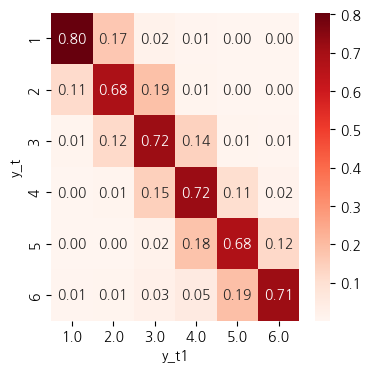

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(g1["transition"], annot=True, fmt='.2f', cmap='Reds')


=== Event study: Treated path (mean) ===


,mean_grade,low56_rate,mean_sales_count_range,mean_unique_customers_range,mean_cancel_rate_range
k,,,,,
-3,3.881217,0.341965,4.455405,4.438553,1.835859
-2,3.917129,0.352102,4.452419,4.450833,1.871658
-1,3.828736,0.340230,4.444444,4.417625,1.961936
0,2.690787,0.000000,4.182139,4.174020,2.079529
1,5.005295,0.675609,5.096717,5.080480,1.687042
2,4.326427,0.488186,4.829880,4.821156,1.816532
3,4.218065,0.462207,4.703704,4.698791,1.787430
6,4.200000,0.445057,4.680000,4.675862,1.842633



=== Event study: Control path (mean) ===


,mean_grade,low56_rate,mean_sales_count_range,mean_unique_customers_range,mean_cancel_rate_range
k,,,,,
-3,2.957729,0.096146,3.525073,3.505180,2.246076
-2,2.958730,0.098810,3.528571,3.525397,2.217990
-1,2.934200,0.089135,3.520658,3.507651,2.227838
0,2.690787,0.000000,3.432757,3.424991,2.453550
1,2.828803,0.059654,3.516767,3.488881,2.123941
2,2.924028,0.085787,3.544166,3.535805,2.149336
3,2.884732,0.090703,3.508314,3.511338,2.134305
6,2.956322,0.103448,3.594483,3.582069,2.214252


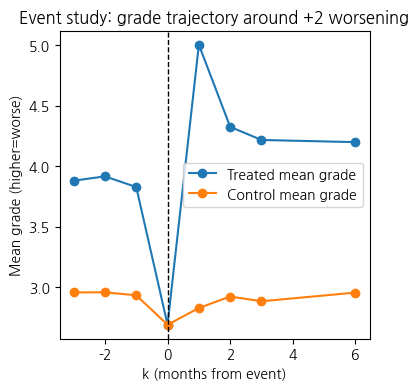

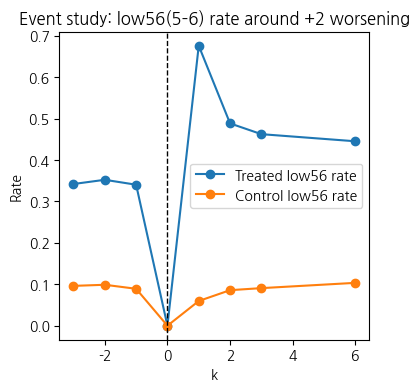


=== KM: time-to-exit low56 after event (up to +6 months) ===


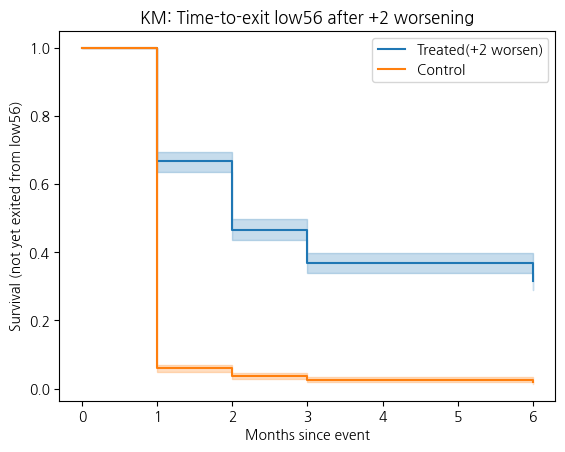

[Logrank] p-value = 2.666e-255


In [ ]:
# ---- 가설2: 지속성 ----
pack = build_event_window_panel(s, lags=[-3,-2,-1,0,1,2,3,6], seed=42, match_max_per_treated=3)
treated_panel = pack["event_panel_treated"]
control_panel = pack["event_panel_control"]

if treated_panel.empty or control_panel.empty:
    print("\n[WARN] +2 악화 사건 패널이 비었거나 통제 매칭이 실패했습니다. 표본을 확인하세요.")
else:
    paths = summarize_event_windows(treated_panel, control_panel)
    print("\n=== Event study: Treated path (mean) ===")
    display(paths["treated_path"])
    print("\n=== Event study: Control path (mean) ===")
    display(paths["control_path"])

    # 라인차트
    try:
        plt.figure(figsize=(4,4))
        plt.plot(paths["treated_path"].index, paths["treated_path"]["mean_grade"], marker="o", label="Treated mean grade")
        plt.plot(paths["control_path"].index, paths["control_path"]["mean_grade"], marker="o", label="Control mean grade")
        plt.axvline(0, color="k", linestyle="--", linewidth=1)
        plt.title("Event study: grade trajectory around +2 worsening")
        plt.xlabel("k (months from event)")
        plt.ylabel("Mean grade (higher=worse)")
        plt.legend(); plt.show()

        if "low56_rate" in paths["treated_path"].columns:
            plt.figure(figsize=(4,4))
            plt.plot(paths["treated_path"].index, paths["treated_path"]["low56_rate"], marker="o", label="Treated low56 rate")
            plt.plot(paths["control_path"].index, paths["control_path"]["low56_rate"], marker="o", label="Control low56 rate")
            plt.axvline(0, color="k", linestyle="--", linewidth=1)
            plt.title("Event study: low56(5–6) rate around +2 worsening")
            plt.xlabel("k"); plt.ylabel("Rate"); plt.legend(); plt.show()
    except Exception as e:
        print(f"[Plot skipped] {e}")

    # 생존곡선
    print("\n=== KM: time-to-exit low56 after event (up to +6 months) ===")
    km_time_to_exit_low56(treated_panel, control_panel, follow_max=6)


=== KM: time-to-exit low56 after event (up to +6 months) ===


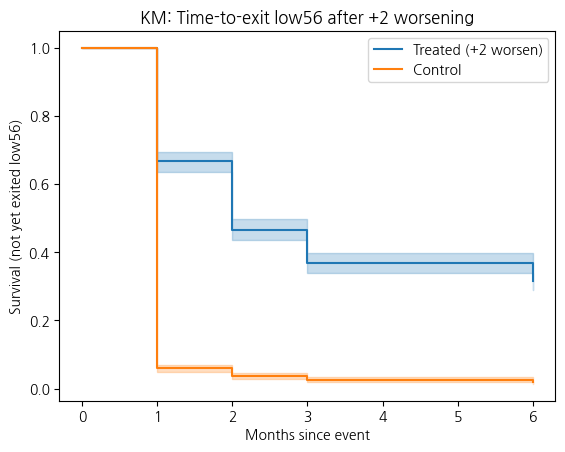

             Treated   Control
n            998.000  2326.000
exit_rate      0.683     0.982
median_time    2.000     1.000
[Logrank] p-value = 2.666e-255, test_stat = 1164.844
[Cox] HR(Treated vs Control) = 0.231 (95% CI 0.210–0.253), p = 2.38e-210

로그랭크 p-value = 2.666e-255
Cox HR = 0.231 (95% CI 0.210–0.253), p = 2.38e-210


In [ ]:
def km_time_to_exit_low56(treated_panel: pd.DataFrame, control_panel: pd.DataFrame, follow_max:int=6,
                          plot: bool = True, try_cox: bool = True):
    """
    사건월(t0) 이후 k=1..follow_max에서 y<5가 되는 최초 시점을 '탈출 이벤트'로 정의.
    lifelines가 있으면 KM 곡선, 로그랭크 p-value, (옵션) Cox HR까지 계산.
    반환: dict(요약 수치 + p-value 등)
    """
    import numpy as np
    import pandas as pd

    def durations(panel):
        if panel.empty:
            return pd.DataFrame(columns=["store_id","t0","duration","event"])
        df = panel.copy()
        df = df.loc[df["k"]>0]  # 사후 기간만
        out=[]
        for (sid, t0), sub in df.groupby(["store_id","t0"]):
            sub = sub.sort_values("k")
            dur = follow_max
            event = 0
            for _, r in sub.iterrows():
                if r["k"]>follow_max: break
                if r["y"] < 5:        # 하위권 탈출
                    dur = int(r["k"])
                    event = 1
                    break
            out.append({"store_id":sid, "t0":t0, "duration":dur, "event":event})
        return pd.DataFrame(out)

    T = durations(treated_panel)
    C = durations(control_panel)

    # 기본 요약
    def _summ(df):
        if df.empty:
            return dict(n=0, exit_rate=np.nan, median_time=np.nan)
        n = int(len(df))
        exit_rate = float(df["event"].mean()) if n>0 else np.nan
        med = float(df.loc[df["event"]==1, "duration"].median()) if df["event"].sum()>0 else np.nan
        return dict(n=n, exit_rate=exit_rate, median_time=med)

    summary = {
        "treated": _summ(T),
        "control": _summ(C),
        "logrank_p": np.nan,
        "logrank_test_stat": np.nan,
        "cox_HR": np.nan,
        "cox_CI95": (np.nan, np.nan),
        "cox_p": np.nan
    }

    has_ll = False
    try:
        import lifelines
        has_ll = True
    except Exception:
        has_ll = False

    # 로그랭크/플롯/Cox
    if has_ll and (not T.empty) and (not C.empty) and (T["event"].sum()+C["event"].sum()>0):
        from lifelines import KaplanMeierFitter
        from lifelines.statistics import logrank_test

        if plot:
            fig = plt.figure()
            kmT, kmC = KaplanMeierFitter(), KaplanMeierFitter()
            ax = None
            kmT.fit(T["duration"], T["event"], label="Treated (+2 worsen)")
            ax = kmT.plot()
            kmC.fit(C["duration"], C["event"], label="Control")
            kmC.plot(ax=ax)
            ax.set_xlabel("Months since event")
            ax.set_ylabel("Survival (not yet exited low56)")
            ax.set_title("KM: Time-to-exit low56 after +2 worsening")
            plt.show()

        lr = logrank_test(T["duration"], C["duration"],
                          event_observed_A=T["event"], event_observed_B=C["event"])
        summary["logrank_p"] = float(lr.p_value)
        summary["logrank_test_stat"] = float(lr.test_statistic) if hasattr(lr, "test_statistic") else np.nan

        # Cox 단일 지표 HR
        if try_cox:
            try:
                from lifelines import CoxPHFitter
                df_cox = pd.concat([
                    T.assign(group=1),
                    C.assign(group=0)
                ], axis=0, ignore_index=True)
                cph = CoxPHFitter()
                cph.fit(df_cox[["duration","event","group"]], duration_col="duration", event_col="event")
                hr = float(np.exp(cph.params_["group"]))
                ci = cph.confidence_intervals_.loc["group"].values  # log-HR CI
                ci = tuple(np.exp(ci))  # HR CI
                p  = float(cph.summary.loc["group","p"])
                summary["cox_HR"] = hr
                summary["cox_CI95"] = (float(ci[0]), float(ci[1]))
                summary["cox_p"]  = p
            except Exception:
                pass

    print(pd.DataFrame({
        "Treated": [summary["treated"]["n"], summary["treated"]["exit_rate"], summary["treated"]["median_time"]],
        "Control": [summary["control"]["n"], summary["control"]["exit_rate"], summary["control"]["median_time"]]
    }, index=["n","exit_rate","median_time"]).round(3))

    # p-value/HR 요약
    if not np.isnan(summary["logrank_p"]):
        print(f"[Logrank] p-value = {summary['logrank_p']:.4g}, test_stat = {summary['logrank_test_stat']:.3f}")
    else:
        print("[Logrank] not computed (lifelines missing or no events).")

    if not np.isnan(summary["cox_HR"]):
        lo, hi = summary["cox_CI95"]
        print(f"[Cox] HR(Treated vs Control) = {summary['cox_HR']:.3f} "
              f"(95% CI {lo:.3f}–{hi:.3f}), p = {summary['cox_p']:.4g}")

    return summary

print("\n=== KM: time-to-exit low56 after event (up to +6 months) ===")
km_summary = km_time_to_exit_low56(treated_panel, control_panel, follow_max=6, plot=True, try_cox=True)

if not np.isnan(km_summary["logrank_p"]):
    print(f"\n로그랭크 p-value = {km_summary['logrank_p']:.4g}")
if not np.isnan(km_summary["cox_HR"]):
    lo, hi = km_summary["cox_CI95"]
    print(f"Cox HR = {km_summary['cox_HR']:.3f} (95% CI {lo:.3f}–{hi:.3f}), p = {km_summary['cox_p']:.4g}")

In [ ]:
# ---- 가설4: 결과 연계(대리지표) ----
out3 = outcome_linkage(s, window_after=3)
if out3.empty:
    print("\n[WARN] 결과 연계(대리지표) 계산 대상이 없습니다.")
else:
    print("\n=== After-event next-3-months: low56 months ≥2 (treated only) ===")
    display(out3.head())
    rate = float(out3["bad_outcome"].mean())
    print(f"Overall bad outcome rate among +2 events: {rate:.3f}")


=== After-event next-3-months: low56 months ≥2 (treated only) ===


,store_id,t_period,low56_count_next3,obs,bad_outcome,overall_bad_rate
0,0050D68B18,2023-12,0,3,0,0.52505
1,0074C4990A,2023-09,1,3,0,0.52505
2,0074C4990A,2024-02,0,3,0,0.52505
3,0080644746,2023-11,2,3,1,0.52505
4,0080644746,2023-12,3,3,1,0.52505


Overall bad outcome rate among +2 events: 0.525


## 파생변수 생성

In [ ]:
import time, sys
import numpy as np
import pandas as pd
from typing import Callable
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, cohen_kappa_score, average_precision_score

In [ ]:
import numpy as np
import pandas as pd
import time, sys
from collections import defaultdict
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, cohen_kappa_score

RANDOM_STATE = 42  # 전역 시드
FIXED_CUM = np.array([0.10, 0.25, 0.50, 0.75, 0.90])  # 클래스 경계 누적비율(고정)

# ---- 유틸: 고정 분위수로 임계값 생성 ----
def learn_quantile_thresholds(yhat_train, cum=FIXED_CUM):
    """
    yhat_train : 회귀 예측값(훈련셋)
    cum        : 누적 분위수(예: [0.10, 0.25, 0.50, 0.75, 0.90])
    반환: 임계값 배열(오름차순), 길이 = len(cum)
    """
    thrs = np.quantile(yhat_train, q=cum, method="linear")
    # 경계가 겹치면 소량 margin
    eps = 1e-6
    for i in range(1, len(thrs)):
        if thrs[i] <= thrs[i-1]:
            thrs[i] = thrs[i-1] + eps
    return thrs

# ---- 유틸: 임계값으로 실수 예측을 등급(1..K)로 매핑 ----
def apply_thresholds(yhat, thresholds):
    return np.digitize(yhat, thresholds, right=False) + 1

# ---- 안전한 시계열 결측 대체(과거→동월→전역) ----
def time_safe_fill(s: pd.DataFrame, col: str, window: int = 6) -> pd.Series:
    """
    1) 점포별 과거 rolling median (shift(1))  -> 임시 채움
    2) 여전히 NaN: 같은 ref_year_month 내 중앙값으로 채움
    3) 여전히 NaN: 전체 중앙값으로 채움
    """
    out = s[col].copy()

    # 1) 점포별 과거 rolling median
    past_med = (
        s.groupby("store_id", group_keys=False)[col]
         .apply(lambda x: x.shift(1).rolling(window, min_periods=1).median())
    )
    out = out.fillna(past_med)

    # 2) 동월 중앙값
    if out.isna().any():
        month_median = s.groupby("ref_year_month")[col].transform("median")
        out = out.fillna(month_median)

    # 3) 전역 중앙값
    if out.isna().any():
        out = out.fillna(s[col].median())

    return out

# ---- 배달 버킷 라벨링(동월 기준) ----
def make_delivery_bucket(s: pd.DataFrame) -> pd.DataFrame:
    """
    delivery_sales_ratio를 동월 기준 tertile로 low/mid/high 나누고,
    결측(=배달 안함)은 none으로 처리. 이후 원핫 생성, 원본 컬럼 drop.
    dtype 충돌 방지를 위해 라벨링 과정은 object로 수행 후 마지막에 Categorical로 변환.
    """
    s = s.copy()

    s["delivery_bucket"] = "none"

    # 1) 배달 여부
    mask = s["delivery_sales_ratio"].notna()

    # 2) 전역 tertile (월 표본 부족 시 fallback)
    if mask.any():
        gq = s.loc[mask, "delivery_sales_ratio"].quantile([1/3, 2/3]).values
        gq_low, gq_high = float(gq[0]), float(gq[1])
    else:
        # 전역에 배달 표본이 전혀 없으면 모두 none으로 유지
        gq_low, gq_high = 0.0, 0.0

    # 3) 월별로 라벨링
    for m, idx in s.loc[mask].groupby("ref_year_month").groups.items():
        vals = s.loc[idx, "delivery_sales_ratio"]
        if len(vals) >= 3:  # 월 표본 충분
            q = vals.quantile([1/3, 2/3]).values
            low_thr, high_thr = float(q[0]), float(q[1])
        else:               # 월 표본 부족 -> 전역 tertile 사용
            low_thr, high_thr = gq_low, gq_high

        labels = pd.cut(
            vals,
            bins=[-np.inf, low_thr, high_thr, np.inf],
            labels=["low", "mid", "high"],
            include_lowest=True,
            right=True,
            ordered=True,
        )
        # delivery_bucket은 현재 object이므로 그대로 문자열을 대입
        s.loc[idx, "delivery_bucket"] = labels.astype(object)

    # 4) 최종적으로만 Categorical로 캐스팅(카테고리 집합 고정)
    s["delivery_bucket"] = pd.Categorical(
        s["delivery_bucket"], categories=["none", "low", "mid", "high"], ordered=True
    )

    # 5) 원핫 생성
    for v in ["none", "low", "mid", "high"]:
        s[f"delivery_bucket__{v}"] = (s["delivery_bucket"] == v).astype("int8")

    # 6) 원본 ratio 드롭
    s = s.drop(columns=["delivery_sales_ratio"])
    return s

# ---- 피처 생성 (t까지 정보로 t+H 예측) ----
def build_features_ordinal(src: pd.DataFrame, window=6, H=1, keep_all=True):
    s = src.copy()
    s = s.sort_values(["store_id","ref_year_month"]).reset_index(drop=True)

    # 1) 결측 대체
    fill_cols = [
        "cancel_rate_range", "district_closure_ratio",
        "returning_customer_ratio", "new_customer_ratio",
        "resident_customer_ratio", "worker_customer_ratio", "floating_customer_ratio"
    ]
    for c in fill_cols:
        if c in s.columns:
            s[c] = time_safe_fill(s, c, window=window)

    # 2) 배달 버킷화
    if "delivery_sales_ratio" in s.columns:
        s = make_delivery_bucket(s)

    g = s.groupby("store_id", group_keys=False)

    # 3) 핵심 원시 피처
    core = [
        "sales_amount_range","sales_count_range","unique_customers_range",
        "industry_sales_rank_ratio","district_sales_rank_ratio",
        "returning_customer_ratio","new_customer_ratio",
        "avg_spending_range","cancel_rate_range",
        "young_ratio","core_ratio","senior_ratio","male_ratio","female_ratio",
        "resident_customer_ratio","worker_customer_ratio","floating_customer_ratio"
    ]
    delivery_ohe = [c for c in s.columns if c.startswith("delivery_bucket__")]
    core = [c for c in core if c in s.columns] + delivery_ohe

    # 4) 롤링 통계
    for c in core:
        s[f"{c}_mean{window}"] = g[c].transform(lambda x: x.rolling(window, min_periods=1).mean())
        s[f"{c}_std{window}"]  = g[c].transform(lambda x: x.rolling(window, min_periods=2).std())
        s[f"{c}_chg3"]         = g[c].transform(lambda x: x - x.shift(3))

    # 5) 간단 추세
    def slope_roll(a, w):
        out = np.full(len(a), np.nan)
        x = np.arange(w)
        for i in range(w-1, len(a)):
            y = a[i-w+1:i+1]
            msk = np.isfinite(y)
            if msk.sum() >= 2:
                m, _ = np.polyfit(x[msk], y[msk], 1)
                out[i] = m
        return out

    for c in ["sales_amount_range","industry_sales_rank_ratio"]:
        if c in s.columns:
            s[f"{c}_slope{window}"] = g[c].transform(
                lambda x: pd.Series(slope_roll(x.to_numpy(), window), index=x.index)
            )

    # 6) 원핫(시간불변 카테고리)
    for col in ["industry_group","business_district"]:
        if col in s.columns:
            vc = s[col].astype("category")
            for v in vc.cat.categories:
                s[f"{col}__{v}"] = (vc == v).astype("int8")

    # 7) 타깃: t+H
    s["y_next"] = g["sales_amount_range"].shift(-H)

    # 8) 예측 가능 시점만
    use_cols = s.select_dtypes(include=[np.number]).columns.tolist()
    X = s[use_cols].drop(columns=["y_next"], errors="ignore")
    y = s["y_next"]
    months = s["ref_year_month"]
    store_ids = s["store_id"]

    if keep_all:
        row_valid = X.notna().all(axis=1)
    else:
        row_valid = (~y.isna()) & X.notna().all(axis=1)

    X = X.loc[row_valid].reset_index(drop=True)
    y = y.loc[row_valid].reset_index(drop=True)
    months = months.loc[row_valid].reset_index(drop=True)
    store_ids = store_ids.loc[row_valid].reset_index(drop=True)

    return X, y, months, store_ids

## 모델링

### 학습 관련 함수

In [ ]:
TOP_KS = (0.03, 0.05)  # 월별 상위 k% 후보: 3%, 5%

# ===== 유틸: k% 목록에 대해 P@k, R@k를 한 번에 계산 =====
def selection_metrics_monthly(df: pd.DataFrame, score_col: str, label_col: str, k_ratios):
    out = {}
    # 월 단위 평균 선정수/양성수(맥락용)
    per_month = []
    for m, sub in df.groupby("month"):
        n = len(sub)
        p = int(sub[label_col].sum())
        per_month.append({"month": m, "N": n, "Pos": p})
    base_df = pd.DataFrame(per_month).sort_values("month")
    out["per_month_stats"] = {
        "N_mean": float(base_df["N"].mean()) if not base_df.empty else float("nan"),
        "Pos_mean": float(base_df["Pos"].mean()) if not base_df.empty else float("nan"),
    }

    for k in k_ratios:
        p_at_k = precision_at_k_month(df, score_col, label_col, k)
        r_at_k = recall_at_k_month(df,    score_col, label_col, k)
        key_p = f"precision@{int(round(k*100))}%"
        key_r = f"recall@{int(round(k*100))}%"
        out[key_p] = float(p_at_k)
        out[key_r] = float(r_at_k)
    return out

# ---- 시계열 확장 CV + Ordinal 평가 ----
def ordinal_timecv_t1(
    X, y, months, min_train_months=6, random_state=RANDOM_STATE, verbose=True, horizon=1
):
    uniq_months = pd.PeriodIndex(months.unique()).sort_values()
    metrics = defaultdict(list)

    if verbose:
        print(f"[Ordinal T{horizon}] folds={max(0, len(uniq_months)-min_train_months)}  "
              f"model=HGBRegressor  window=6  horizon={horizon}")
        print("-"*90)

    for i in range(min_train_months, len(uniq_months)):
        m_val = uniq_months[i]
        tr_mask = pd.Series(months).isin(uniq_months[:i])
        va_mask = (pd.Series(months) == m_val)

        Xtr, ytr = X[tr_mask], y[tr_mask]
        Xva, yva = X[va_mask], y[va_mask]

        # 훈련 타깃 NaN 제거
        tr_ok = np.isfinite(np.asarray(ytr))
        Xtr_use = Xtr[tr_ok]
        ytr_use = ytr[tr_ok]

        # 검증 타깃 전부 NaN이면 스킵
        if not np.isfinite(np.asarray(yva)).any():
            if verbose:
                print(f"[{i-min_train_months+1:02d}/{len(uniq_months)-min_train_months}] "
                      f"t={m_val}, target={m_val+horizon} : skip (no valid targets)")
            continue

        if (len(Xtr_use) < 50) or (pd.Series(ytr_use).nunique() < 2) or (len(Xva) < 10):
            if verbose:
                print(f"[{i-min_train_months+1:02d}/{len(uniq_months)-min_train_months}] "
                      f"t={m_val}, target={m_val+horizon} : skip "
                      f"(n_tr={len(Xtr_use)}, classes={pd.Series(ytr_use).nunique()}, n_va={len(Xva)})")
            continue

        t0 = time.time()
        reg = HistGradientBoostingRegressor(
            max_depth=3, learning_rate=0.05, max_bins=255,
            l2_regularization=0.0, early_stopping=True,
            random_state=random_state, loss="squared_error", verbose=0
        )
        reg.fit(Xtr_use, ytr_use)

        yhat_tr = reg.predict(Xtr_use)
        thresholds = learn_quantile_thresholds(yhat_tr, cum=FIXED_CUM)

        yhat_va = reg.predict(Xva)
        ypred_va = apply_thresholds_safe(yhat_va, thresholds)

        mae, qwk = metrics_safe(yva, ypred_va)
        metrics["month"].append(str(m_val))
        metrics["mae"].append(mae)
        metrics["qwk"].append(qwk)

        if verbose:
            dur = time.time() - t0
            print(f"[{i-min_train_months+1:02d}/{len(uniq_months)-min_train_months}] "
                  f"t={m_val}, target={m_val+horizon} "
                  f"| n_tr={len(Xtr_use)} n_va={len(Xva)} | MAE={mae if np.isfinite(mae) else np.nan:.3f} "
                  f"QWK={qwk if np.isfinite(qwk) else np.nan:.3f}  ({dur:.2f}s)")
            sys.stdout.flush()

    out = pd.DataFrame(metrics)
    summ = out.agg({"mae":["mean","std"], "qwk":["mean","std"]}) if not out.empty else pd.DataFrame()
    if verbose and not out.empty:
        print("-"*90); print(summ)
    return out, summ

def _sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def soft_ordinal_probs(yhat_real: np.ndarray, thresholds: np.ndarray, tau: float = 0.5) -> np.ndarray:
    """
    thresholds(K-1)와 연속 예측으로 K-클래스 확률 근사.
    """
    th = thresholds.reshape(1, -1)               # (1, K-1)
    yh = yhat_real.reshape(-1, 1)                # (N, 1)
    cdfs = _sigmoid((th - yh) / max(1e-6, tau))  # (N, K-1)
    cdfs = np.concatenate([np.zeros((len(yhat_real),1)), cdfs, np.ones((len(yhat_real),1))], axis=1)  # (N, K+1)
    probs = np.clip(cdfs[:,1:] - cdfs[:,:-1], 1e-9, 1.0)  # (N, K)
    probs = probs / probs.sum(axis=1, keepdims=True)
    return probs

# ---- 공용: 월별 Precision@K / Recall@K ----
def precision_at_k_month(df, score_col, label_col, k_ratio: float):
    vals=[]
    for _, sub in df.groupby("month"):
        if len(sub) < 10:
            continue
        k = max(1, int(round(len(sub)*k_ratio)))
        top_pred = sub.sort_values(score_col, ascending=False).index[:k]
        pos_idx  = sub.index[sub[label_col]==1]
        tp = len(set(top_pred).intersection(set(pos_idx)))
        vals.append(tp/k)
    return float(np.mean(vals)) if vals else np.nan

def recall_at_k_month(df, score_col, label_col, k_ratio: float):
    vals=[]
    for _, sub in df.groupby("month"):
        pos_idx = sub.index[sub[label_col]==1]
        P = len(pos_idx)
        if len(sub) < 10 or P==0:
            continue
        k = max(1, int(round(len(sub)*k_ratio)))
        top_pred = sub.sort_values(score_col, ascending=False).index[:k]
        tp = len(set(top_pred).intersection(set(pos_idx)))
        vals.append(tp / P)   # 분모=양성 수
    return float(np.mean(vals)) if vals else np.nan

# ---- 공용 러너: 임의의 Regressor 팩토리를 받아서 expanding CV 수행 + Tier0 산출 ----
def run_regressor_cv_with_tier0(
    X, y, months, model_factory: Callable[[], object],
    min_train_months: int = 6, horizon: int = 1, tau: float = 0.5, verbose: bool = True
) -> Dict[str, object]:

    uniq_months = pd.PeriodIndex(pd.Series(months).unique()).sort_values()
    K = int(np.nanmax(y))  # y가 0..K-1인 가정. (1..K면 +1 하세요)
    rows_cv, rows_pred = [], []

    for i in range(min_train_months, len(uniq_months)):
        m_val = uniq_months[i]
        tr_mask = pd.Series(months).isin(uniq_months[:i])
        va_mask = (pd.Series(months) == m_val)

        Xtr, ytr = X[tr_mask], y[tr_mask]
        Xva, yva = X[va_mask], y[va_mask]

        # 훈련 타깃 NaN 제거
        ytr_np = np.asarray(ytr)
        tr_ok = np.isfinite(ytr_np)
        Xtr_use = Xtr[tr_ok]; ytr_use = ytr[tr_ok]

        # 검증 타깃 유효성
        yva_np = np.asarray(yva)
        if not np.isfinite(yva_np).any():
            if verbose:
                print(f"[run] t={m_val}, target={m_val+horizon} : skip (no valid targets)")
            continue

        if (len(Xtr_use) < 50) or (pd.Series(ytr_use).nunique() < 2) or (len(Xva) < 10):
            if verbose:
                print(f"[run] t={m_val}, target={m_val+horizon} : skip "
                      f"(n_tr={len(Xtr_use)}, classes={pd.Series(ytr_use).nunique()}, n_va={len(Xva)})")
            continue

        # --- 모델 학습 ---
        model = model_factory()
        model.fit(Xtr_use, ytr_use)

        # --- 훈련 예측으로 컷 ---
        yhat_tr = model.predict(Xtr_use)
        thresholds = learn_quantile_thresholds(yhat_tr, cum=FIXED_CUM)

        # --- 검증 예측 + 안전 등급화 ---
        yhat_va_real = model.predict(Xva)
        ypred_va = apply_thresholds_safe(yhat_va_real, thresholds)

        mae, qwk = metrics_safe(yva_np, ypred_va)
        rows_cv.append({"month": str(m_val), "mae": mae, "qwk": qwk})

        # ---- Tier 0 확률/위험 스코어 ----
        probs = soft_ordinal_probs(yhat_va_real, thresholds, tau=float(tau))  # (N, K)
        p_low56 = probs[:, max(0, K-2):].sum(axis=1) if K >= 2 else np.zeros(len(Xva))

        # 급락 스코어(선택): y_t 피처 없으면 skip
        risk_worsen_ge2 = np.full(len(Xva), np.nan, dtype=float)
        if "sales_amount_range" in Xva.columns:
            y_t = Xva["sales_amount_range"].astype(float).to_numpy()
            cprobs = probs.cumsum(axis=1)
            idx_y_t = np.clip(np.nan_to_num(y_t, nan=0).astype(int), 0, K-1)
            mask_oob = (np.nan_to_num(y_t, nan=K) + 2) > K
            tmp = 1.0 - cprobs[np.arange(len(y_t)), idx_y_t]
            risk_worsen_ge2 = np.where(mask_oob, 0.0, tmp)

        for k in range(len(yva)):
            rows_pred.append({
                "month": str(m_val),
                "y_true": int(yva_np[k]) if np.isfinite(yva_np[k]) else np.nan,
                "y_pred": int(ypred_va[k]) if np.isfinite(ypred_va[k]) else np.nan,
                "yhat_real": float(yhat_va_real[k]) if np.isfinite(yhat_va_real[k]) else np.nan,
                "y_t": int(y_t[k]) if ("sales_amount_range" in Xva.columns and np.isfinite(y_t[k])) else np.nan,
                "p_low56": float(p_low56[k]) if np.isfinite(p_low56[k]) else np.nan,
                "risk_worsen_ge2": float(risk_worsen_ge2[k]) if np.isfinite(risk_worsen_ge2[k]) else np.nan
            })

        if verbose:
            print(f"[{i-min_train_months+1:02d}/{len(uniq_months)-min_train_months}] "
                  f"t={m_val}, target={m_val+horizon} | MAE={mae if np.isfinite(mae) else np.nan:.3f} "
                  f"QWK={qwk if np.isfinite(qwk) else np.nan:.3f}")

    cv_df = pd.DataFrame(rows_cv)
    summ = cv_df.agg({"mae":["mean","std"], "qwk":["mean","std"]}) if not cv_df.empty else pd.DataFrame()
    pred_df = pd.DataFrame(rows_pred)

    # ---- Tier 0 평가 ----
    risk_metrics = {}
    if not pred_df.empty and "risk_worsen_ge2" in pred_df.columns:
        df2 = pred_df.copy()
        df2["label_worsen_ge2"] = np.where(
            np.isfinite(df2["y_true"]) & np.isfinite(df2["y_t"]),
            (df2["y_true"] >= (df2["y_t"] + 2)).astype(int),
            np.nan
        )
        m2 = np.isfinite(df2["label_worsen_ge2"]) & np.isfinite(df2["risk_worsen_ge2"])
        if m2.sum() > 0:
            y2 = df2.loc[m2, "label_worsen_ge2"].astype(int).to_numpy()
            s2 = df2.loc[m2, "risk_worsen_ge2"].to_numpy()
            try:
                pr2 = average_precision_score(y2, s2)
            except Exception:
                pr2 = np.nan

            drop_k_stats = selection_metrics_monthly(
                df2.loc[m2, ["month","risk_worsen_ge2","label_worsen_ge2"]]
                   .rename(columns={"risk_worsen_ge2":"score","label_worsen_ge2":"label"}),
                score_col="score", label_col="label", k_ratios=TOP_KS
            )
            risk_metrics["drop_ge2"] = {
                "base_rate": float(np.mean(y2)) if y2.size else np.nan,
                "PR_AUC": float(pr2),
                **drop_k_stats,
            }

    return {
        "cv_table": cv_df,
        "summary": summ,
        "pred_samples": pred_df,
        "risk_metrics": risk_metrics
    }

def summarize_delta_distribution(pred_samples: pd.DataFrame) -> dict:
    """
    pred_samples: run_regressor_cv_with_tier0(...)가 반환한 검증 샘플 테이블
                  (필수 컬럼: y_true, y_pred, month)
    반환:
      {
        "overall": {"p_delta0":..., "p_abs1":..., "p_ge2":..., "N":...},
        "by_month": DataFrame(columns=["month","p_ge2","N"])  # 선택적으로 PPT에 사용
      }
    """
    df = pred_samples.copy()
    if df.empty:
        return {"overall": {"p_delta0": np.nan, "p_abs1": np.nan, "p_ge2": np.nan, "N": 0},
                "by_month": pd.DataFrame(columns=["month","p_ge2","N"])}

    delta = (df["y_true"] - df["y_pred"]).abs()
    n = len(delta)
    p0  = float((delta == 0).mean())
    p1  = float((delta == 1).mean())
    pge2 = float((delta >= 2).mean())

    by_m = (
        df.assign(delta=delta)
          .groupby("month")
          .apply(lambda x: pd.Series({"p_ge2": float((x["delta"]>=2).mean()), "N": len(x)}))
          .reset_index()
          .sort_values("month")
    )
    return {"overall": {"p_delta0": p0, "p_abs1": p1, "p_ge2": pge2, "N": int(n)},
            "by_month": by_m}

### 학습 및 평가

In [ ]:
# ----- CatBoost Regressor (사일런트) -----
def make_catboost_regressor():
    return CatBoostRegressor(
        iterations=700,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3.0,
        loss_function="RMSE",  # 회귀 출력 → 컷 매핑
        random_seed=RANDOM_STATE,
        verbose=False
    )

In [ ]:
base_cols = ['store_id','ref_year_month',
             'sales_amount_range','sales_count_range','unique_customers_range',
             'avg_spending_range','cancel_rate_range',
             'industry_sales_ratio','industry_sales_count_ratio',
             'industry_sales_rank_ratio','district_sales_rank_ratio',
             'industry_closure_ratio','district_closure_ratio',
             'young_ratio','core_ratio','senior_ratio','male_ratio','female_ratio',
             'returning_customer_ratio','new_customer_ratio',
             'resident_customer_ratio','worker_customer_ratio','floating_customer_ratio',
             'industry_group','business_district']

df = total_df.loc[:, [c for c in base_cols if c in total_df.columns]].copy()
df = df.sort_values(["store_id","ref_year_month"]).reset_index(drop=True)

In [ ]:
X_1, y_1, m_1, id_1 = build_features_ordinal(df, window=6, H=1)
X_2, y_2, m_2, id_2 = build_features_ordinal(df, window=6, H=2)
X_3, y_3, m_3, id_3 = build_features_ordinal(df, window=6, H=3)

xym_lst = [(X_1, y_1, m_1), (X_2, y_2, m_2), (X_3, y_3, m_3)]

In [ ]:
# 예측 선행 기간(H) = 1,2,3에 대해  수행
for xym in xym_lst:
  X_h, y_h, m_h = xym
  # 1) CV 실행
  res = run_regressor_cv_with_tier0(
      X=X_h, y=y_h, months=m_h,
      model_factory=make_catboost_regressor,
      min_train_months=6, horizon=1, tau=0.5, verbose=True
  )

  # 2) 급락(+2) 탐지 성능 요약 (3%/5%)
  drop_metrics = res["risk_metrics"]["drop_ge2"]
  display(drop_metrics)

  # 3) 등급 예측 오차(Δ) 분포
  delta_stat = summarize_delta_distribution(res["pred_samples"])
  display(delta_stat['overall'])
  display(delta_stat['by_month'])

[01/13] t=2023-12, target=2024-01 | MAE=1.079 QWK=0.717
[02/13] t=2024-01, target=2024-02 | MAE=1.019 QWK=0.735
[03/13] t=2024-02, target=2024-03 | MAE=0.862 QWK=0.778
[04/13] t=2024-03, target=2024-04 | MAE=0.996 QWK=0.753
[05/13] t=2024-04, target=2024-05 | MAE=0.949 QWK=0.767
[06/13] t=2024-05, target=2024-06 | MAE=1.017 QWK=0.746
[07/13] t=2024-06, target=2024-07 | MAE=1.030 QWK=0.734
[08/13] t=2024-07, target=2024-08 | MAE=1.022 QWK=0.739
[09/13] t=2024-08, target=2024-09 | MAE=0.998 QWK=0.736
[10/13] t=2024-09, target=2024-10 | MAE=0.948 QWK=0.757
[11/13] t=2024-10, target=2024-11 | MAE=0.997 QWK=0.751
[12/13] t=2024-11, target=2024-12 | MAE=0.986 QWK=0.756
[run] t=2024-12, target=2025-01 : skip (no valid targets)


{'base_rate': 0.0125617600447469,
 'PR_AUC': 0.36400031161758134,
 'per_month_stats': {'N_mean': 3575.6666666666665,
  'Pos_mean': 44.916666666666664},
 'precision@3%': 0.2307130277470226,
 'recall@3%': 0.5361618789314869,
 'precision@5%': 0.15800357216349906,
 'recall@5%': 0.6136712455339907}

{'p_delta0': 0.13752680152885244,
 'p_abs1': 0.7422625151486902,
 'p_ge2': 0.12021068332245735,
 'N': 42908}

,month,p_ge2,N
0,2023-12,0.160097,3298.0
1,2024-01,0.128542,3353.0
2,2024-02,0.075815,3403.0
3,2024-03,0.126487,3447.0
4,2024-04,0.088059,3509.0
5,2024-05,0.125282,3552.0
6,2024-06,0.141667,3600.0
7,2024-07,0.126679,3647.0
8,2024-08,0.135340,3687.0
9,2024-09,0.100508,3741.0


[01/13] t=2023-12, target=2024-01 | MAE=1.078 QWK=0.709
[02/13] t=2024-01, target=2024-02 | MAE=0.887 QWK=0.770
[03/13] t=2024-02, target=2024-03 | MAE=0.908 QWK=0.765
[04/13] t=2024-03, target=2024-04 | MAE=0.944 QWK=0.759
[05/13] t=2024-04, target=2024-05 | MAE=0.981 QWK=0.749
[06/13] t=2024-05, target=2024-06 | MAE=1.055 QWK=0.716
[07/13] t=2024-06, target=2024-07 | MAE=1.061 QWK=0.716
[08/13] t=2024-07, target=2024-08 | MAE=1.027 QWK=0.726
[09/13] t=2024-08, target=2024-09 | MAE=0.960 QWK=0.752
[10/13] t=2024-09, target=2024-10 | MAE=0.964 QWK=0.745
[11/13] t=2024-10, target=2024-11 | MAE=1.006 QWK=0.740
[run] t=2024-11, target=2024-12 : skip (no valid targets)
[run] t=2024-12, target=2025-01 : skip (no valid targets)


{'base_rate': 0.01659581007017364,
 'PR_AUC': 0.3676731081307802,
 'per_month_stats': {'N_mean': 3549.6363636363635,
  'Pos_mean': 58.90909090909091},
 'precision@3%': 0.271685986883015,
 'recall@3%': 0.48052711743743937,
 'precision@5%': 0.1928327604862755,
 'recall@5%': 0.5652284208057213}

{'p_delta0': 0.15317830251498232,
 'p_abs1': 0.7175126773549148,
 'p_ge2': 0.12930902013010295,
 'N': 39046}

,month,p_ge2,N
0,2023-12,0.170103,3298.0
1,2024-01,0.077841,3353.0
2,2024-02,0.100206,3403.0
3,2024-03,0.103858,3447.0
4,2024-04,0.118552,3509.0
5,2024-05,0.167230,3552.0
6,2024-06,0.164444,3600.0
7,2024-07,0.148067,3647.0
8,2024-08,0.113371,3687.0
9,2024-09,0.115477,3741.0


[01/13] t=2023-12, target=2024-01 | MAE=0.928 QWK=0.750
[02/13] t=2024-01, target=2024-02 | MAE=0.939 QWK=0.751
[03/13] t=2024-02, target=2024-03 | MAE=0.908 QWK=0.757
[04/13] t=2024-03, target=2024-04 | MAE=0.996 QWK=0.735
[05/13] t=2024-04, target=2024-05 | MAE=1.029 QWK=0.719
[06/13] t=2024-05, target=2024-06 | MAE=1.074 QWK=0.705
[07/13] t=2024-06, target=2024-07 | MAE=1.051 QWK=0.714
[08/13] t=2024-07, target=2024-08 | MAE=0.973 QWK=0.746
[09/13] t=2024-08, target=2024-09 | MAE=0.983 QWK=0.739
[10/13] t=2024-09, target=2024-10 | MAE=0.968 QWK=0.741
[run] t=2024-10, target=2024-11 : skip (no valid targets)
[run] t=2024-11, target=2024-12 : skip (no valid targets)
[run] t=2024-12, target=2025-01 : skip (no valid targets)


{'base_rate': 0.019865482305531118,
 'PR_AUC': 0.32892445831716827,
 'per_month_stats': {'N_mean': 3523.7, 'Pos_mean': 70.0},
 'precision@3%': 0.30771830542670037,
 'recall@3%': 0.46406748828008426,
 'precision@5%': 0.2165149704416848,
 'recall@5%': 0.5404347229239688}

{'p_delta0': 0.1638050912393223,
 'p_abs1': 0.7025002128444533,
 'p_ge2': 0.13369469591622443,
 'N': 35237}

,month,p_ge2,N
0,2023-12,0.101273,3298.0
1,2024-01,0.111542,3353.0
2,2024-02,0.096679,3403.0
3,2024-03,0.138091,3447.0
4,2024-04,0.157880,3509.0
5,2024-05,0.181588,3552.0
6,2024-06,0.166667,3600.0
7,2024-07,0.119276,3647.0
8,2024-08,0.128289,3687.0
9,2024-09,0.131248,3741.0


### 전체 가맹점 예측

In [ ]:
import json

# === 사용자 환경 변수 ===
CUTOFF_T = pd.Period("2024-12", freq="M")
TAU = 0.5

def train_full_and_predict_future(df: pd.DataFrame, horizons=(1,2,3), window=6):
    all_summary, all_probs = [], []

    for H in horizons:
        # (A) 훈련용 뷰 (라벨 필수)
        X_train, y_train, m_train, sid_train = build_features_ordinal(df, window=window, H=H, keep_all=False)
        m_train = pd.PeriodIndex(m_train)
        tr_idx = (m_train <= CUTOFF_T)
        Xtr, ytr = X_train.loc[tr_idx], y_train.loc[tr_idx]

        # (B) 추론용 뷰 (라벨 불필요)
        X_all, _, m_all, sid_all = build_features_ordinal(df, window=window, H=H, keep_all=True)
        m_all = pd.PeriodIndex(m_all)
        te_idx = (m_all == CUTOFF_T)
        Xte = X_all.loc[te_idx].copy()
        sid_te = sid_all.loc[te_idx].reset_index(drop=True)
        yt_te  = Xte["sales_amount_range"].astype(int).reset_index(drop=True)

        if len(Xte) == 0:
            raise ValueError(f"No rows found for inference at t={CUTOFF_T} with H={H}. "
                             "Use keep_all=True to keep the last month rows.")

        # 모델 학습 및 컷팅
        model = make_catboost_regressor()
        model.fit(Xtr, ytr)
        yhat_tr = model.predict(Xtr)
        thresholds = learn_quantile_thresholds(yhat_tr, cum=FIXED_CUM)

        # 예측 + 확률
        yhat_real = model.predict(Xte)
        yhat_grade = apply_thresholds_safe(yhat_real, thresholds)
        probs = soft_ordinal_probs(yhat_real, thresholds, tau=TAU)
        K = probs.shape[1]
        p_low56 = probs[:, max(0, K-2):].sum(axis=1)

        cprobs = probs.cumsum(axis=1)
        risk_worsen_ge2 = 1.0 - cprobs[np.arange(len(yt_te)), np.clip(yt_te.values, 0, K-1)]
        risk_worsen_ge2 = np.where((yt_te.values + 2) > K, 0.0, risk_worsen_ge2)

        target_month = str(CUTOFF_T + H)

        summary_df = pd.DataFrame({
            "store_id": sid_te.astype(str).values,
            "t_ref": [str(CUTOFF_T)]*len(Xte),
            "target_month": [target_month]*len(Xte),
            "horizon": [H]*len(Xte),
            "tau": [TAU]*len(Xte),
            "yhat_real": yhat_real.astype(float),
            "yhat_grade": yhat_grade.astype(int),
            "p_low56": p_low56.astype(float),
            "risk_worsen_ge2": risk_worsen_ge2.astype(float),
            "y_t": yt_te.astype(int),
            "thresholds": [json.dumps(list(map(float, thresholds)))]*len(Xte),
        })
        all_summary.append(summary_df)

        probs_long = (
            pd.DataFrame(probs, columns=[f"p{k}" for k in range(1, K+1)])
            .assign(store_id=sid_te.astype(str).values,
                    t_ref=str(CUTOFF_T),
                    target_month=target_month,
                    horizon=H)
            .melt(id_vars=["store_id","t_ref","target_month","horizon"],
                  var_name="class_k", value_name="prob")
        )
        probs_long["class_k"] = probs_long["class_k"].str.extract(r"p(\d+)").astype(int)
        all_probs.append(probs_long)

    return pd.concat(all_summary, ignore_index=True), pd.concat(all_probs, ignore_index=True)

In [ ]:
def apply_thresholds_safe(y_cont, thresholds):
    """
    연속 예측값 -> 등급. NaN 입력은 NaN 출력.
    thresholds: 오름차순 1D (길이 = 등급 수 - 1)
    """
    y_cont = np.asarray(y_cont, dtype=float)
    thr = np.asarray(thresholds, dtype=float)

    # 임계값에 NaN 있으면 fallback: 균등간격
    if (thr.size == 0) or (not np.all(np.isfinite(thr))) or (np.any(np.diff(np.nan_to_num(thr, nan=np.inf)) < 0)):
        lo = np.nanmin(y_cont)
        hi = np.nanmax(y_cont)
        if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
            return np.full_like(y_cont, fill_value=np.nan)
        # 5등급 예시: 절반/기본값, 필요 시 조정
        cuts = np.linspace(lo, hi, 6)[1:-1]  # 4개 컷 → 5등급
        thr = cuts

    bins = np.r_[-np.inf, thr, np.inf]
    # digitize는 NaN을 처리 못하므로 mask로 분리
    out = np.full(y_cont.shape, np.nan)
    mask = np.isfinite(y_cont)
    out[mask] = np.digitize(y_cont[mask], bins, right=False) - 1  # 0..K-1
    return out

from sklearn.metrics import mean_absolute_error, cohen_kappa_score

def metrics_safe(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan, np.nan
    return (mean_absolute_error(y_true[m], y_pred[m]),
            cohen_kappa_score(y_true[m].astype(int), y_pred[m].astype(int), weights="quadratic"))

In [ ]:
# 실행
pred_summary, prob_table = train_full_and_predict_future(df, horizons=(1,2,3), window=6)

In [ ]:
pred_summary.head()

,store_id,t_ref,target_month,horizon,tau,yhat_real,yhat_grade,p_low56,risk_worsen_ge2,y_t,thresholds
0,000F03E44A,2024-12,2025-01,1,0.5,5.367028,5,0.867842,0.000000,6,"[1.6123306216031328, 2.5336023485201284, 3.4759048709662843, 4.426023434745074, 5.318703430633439]"
1,002816BA73,2024-12,2025-01,1,0.5,2.953539,2,0.049975,0.049975,3,"[1.6123306216031328, 2.5336023485201284, 3.4759048709662843, 4.426023434745074, 5.318703430633439]"
2,003473B465,2024-12,2025-01,1,0.5,5.867573,5,0.947005,0.000000,6,"[1.6123306216031328, 2.5336023485201284, 3.4759048709662843, 4.426023434745074, 5.318703430633439]"
3,003AC99735,2024-12,2025-01,1,0.5,2.531019,1,0.022096,0.022096,3,"[1.6123306216031328, 2.5336023485201284, 3.4759048709662843, 4.426023434745074, 5.318703430633439]"
4,0041E4E5AE,2024-12,2025-01,1,0.5,2.241656,1,0.012509,0.078096,2,"[1.6123306216031328, 2.5336023485201284, 3.4759048709662843, 4.426023434745074, 5.318703430633439]"


In [ ]:
prob_table.head()

,store_id,t_ref,target_month,horizon,class_k,prob
0,000F03E44A,2024-12,2025-01,1,1,0.000548
1,002816BA73,2024-12,2025-01,1,1,0.064019
2,003473B465,2024-12,2025-01,1,1,0.000201
3,003AC99735,2024-12,2025-01,1,1,0.137362
4,0041E4E5AE,2024-12,2025-01,1,1,0.221206


In [ ]:
# 가맹점별 최종 예측 결과표
key = ['store_id','t_ref','target_month','horizon']
pred = pred_summary[key + ['yhat_grade']].copy()

tmp = prob_table.merge(pred, on=key, how='inner')
p_pred = (
    tmp.loc[tmp['class_k'].eq(tmp['yhat_grade']), key + ['prob']]
        .rename(columns={'prob': 'yhat_prob'})
)

fin_sales_results = pred_summary.merge(p_pred, on=key, how='left', validate='one_to_one')
fin_sales_results[['store_id', 'target_month',	'horizon', 'yhat_grade',
                   'yhat_prob',	'risk_worsen_ge2', 'y_t']]

,store_id,target_month,horizon,yhat_grade,yhat_prob,risk_worsen_ge2,y_t
0,000F03E44A,2025-01,1,5,0.343698,0.000000,6
1,002816BA73,2025-01,1,2,0.237543,0.049975,3
2,003473B465,2025-01,1,5,0.197168,0.000000,6
3,003AC99735,2025-01,1,1,0.137362,0.022096,3
4,0041E4E5AE,2025-01,1,1,0.221206,0.078096,2
...,...,...,...,...,...,...,...
11722,FF8A45E182,2025-03,3,2,0.275830,0.042235,3
11723,FFAC8CC0F7,2025-03,3,5,0.246766,0.000000,6
11724,FFD5654C3D,2025-03,3,2,0.161894,0.089678,3
11725,FFEDAC5747,2025-03,3,0,NaN,0.055930,1
